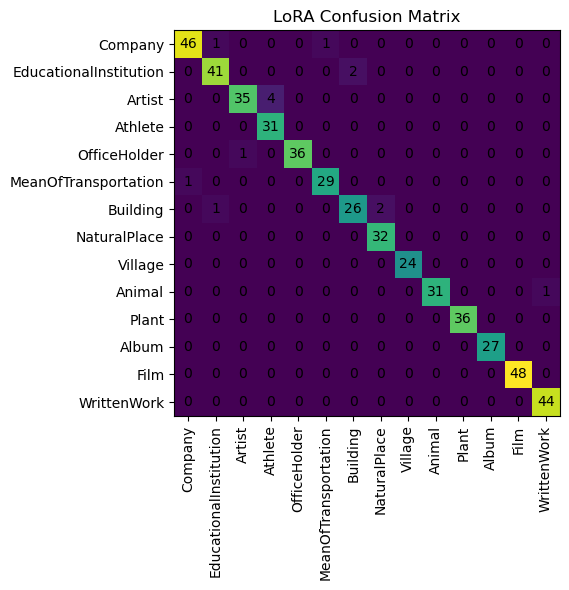

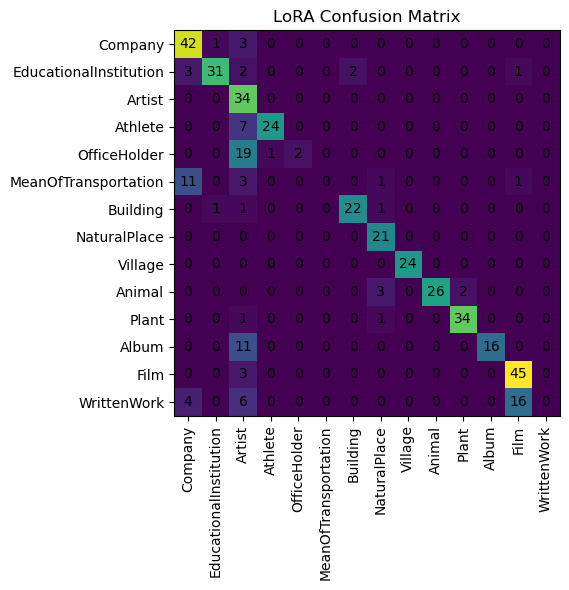

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# read the Excel
df = pd.read_excel("./compare_out/lora_confusion_matrix.xlsx", index_col=0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(df.values)
ax.set_xticks(range(len(df.columns)))
ax.set_xticklabels(df.columns, rotation=90)
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df.index)
ax.set_title("LoRA Confusion Matrix")

# put numbers on cells
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        ax.text(j, i, df.iat[i, j], ha="center", va="center")

plt.tight_layout()
plt.savefig("./output/lora_confusion_matrix.png", dpi=200)
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

# read the Excel
df = pd.read_excel("./compare_out/base_confusion_matrix.xlsx", index_col=0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(df.values)
ax.set_xticks(range(len(df.columns)))
ax.set_xticklabels(df.columns, rotation=90)
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df.index)
ax.set_title("LoRA Confusion Matrix")

# put numbers on cells
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        ax.text(j, i, df.iat[i, j], ha="center", va="center")

plt.tight_layout()
plt.savefig("./output/base_confusion_matrix.png", dpi=200)
plt.show()


In [11]:
import os
import numpy as np
from datasets import load_dataset

SEED = 42
TOTAL_SAMPLES_FOR_TRAINING = 5000
OUT_DIR = "./output"
os.makedirs(OUT_DIR, exist_ok=True)

DBPEDIA_LABELS = [
    "Company",
    "EducationalInstitution",
    "Artist",
    "Athlete",
    "OfficeHolder",
    "MeanOfTransportation",
    "Building",
    "NaturalPlace",
    "Village",
    "Animal",
    "Plant",
    "Album",
    "Film",
    "WrittenWork",
]

# load original train
ds = load_dataset("fancyzhx/dbpedia_14")
train_orig = ds["train"]

# make our own shuffled index list
rng = np.random.default_rng(SEED)
perm = rng.permutation(len(train_orig))

# these are the original positions we actually used
used_orig_indices = perm[:TOTAL_SAMPLES_FOR_TRAINING]

# save a human readable file
txt_path = os.path.join(OUT_DIR, "finetune_samples.txt")
with open(txt_path, "w", encoding="utf-8") as f:
    for idx in used_orig_indices:
        ex = train_orig[int(idx)]
        label_name = DBPEDIA_LABELS[ex["label"]]
        title = (ex["title"] or "").replace("\n", " ").strip()
        content = (ex["content"] or "").replace("\n", " ").strip()
        f.write(f"original_idx={idx}\n")
        f.write(f"label={label_name}\n")
        f.write(f"title={title}\n")
        f.write(f"content={content}\n")
        f.write("-" * 80 + "\n")

# save a clean file with only original indices
idx_path = os.path.join(OUT_DIR, "finetune_original_indices.txt")
with open(idx_path, "w", encoding="utf-8") as f:
    for idx in used_orig_indices:
        f.write(str(int(idx)) + "\n")

print("Saved", len(used_orig_indices), "original indices.")
print("Files:")
print(" -", txt_path)
print(" -", idx_path)


Saved 5000 original indices.
Files:
 - ./output/finetune_samples.txt
 - ./output/finetune_original_indices.txt


In [11]:
import torch
import difflib
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# -----------------------------
# Config
# -----------------------------
MODEL_ID = "meta-llama/Llama-3.2-1B-Instruct"
LORA_DIR = "./lora_output/final_adapter"  # change if your adapter is elsewhere
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# <<< PUT YOUR TEST INDICES HERE >>>
# Example: the ones you showed: 6863, 1644, 2783, 4816, ...
TEST_INDICES = [1644, 2783, 4816, 6863]  # <- edit this list
TEST_INDICES = sorted(TEST_INDICES)
print("Selected test indices:", TEST_INDICES)

# -----------------------------
# DBpedia label set
# -----------------------------
DBPEDIA_LABELS = [
    "Company",
    "EducationalInstitution",
    "Artist",
    "Athlete",
    "OfficeHolder",
    "MeanOfTransportation",
    "Building",
    "NaturalPlace",
    "Village",
    "Animal",
    "Plant",
    "Album",
    "Film",
    "WrittenWork",
]

def build_prompt(title, content, label_names):
    """Same style as in compare_base_vs_lora.py."""
    content = (content or "")[:600]
    cats = ", ".join(label_names)
    return (
        "You are a classifier for the DBpedia14 dataset.\n"
        "Your job is to assign exactly one category to the article.\n"
        "Answer with only one category name, exactly as written in the list.\n\n"
        f"Categories: {cats}\n\n"
        f"Title: {title}\n"
        f"Content: {content}\n"
        "Category:"
    )

def normalize_to_label(answer_text, label_names):
    """Map raw generation to one of the DBpedia labels."""
    answer_text = answer_text.strip()
    if not answer_text:
        return "UNKNOWN"

    first_line = answer_text.splitlines()[0].strip()
    token = first_line.split()[0].strip(".,:;! ")

    # exact
    if token in label_names:
        return token

    # case-insensitive
    for name in label_names:
        if token.lower() == name.lower():
            return name

    # fuzzy
    match = difflib.get_close_matches(token, label_names, n=1)
    return match[0] if match else "UNKNOWN"

# -----------------------------
# Load tokenizer and models
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"

# Base model
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
)
base_model.to(DEVICE)
base_model.eval()

# LoRA model
lora_base = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
)
lora_model = PeftModel.from_pretrained(lora_base, LORA_DIR)
lora_model.to(DEVICE)
lora_model.eval()

print("Models loaded.")

# -----------------------------
# Load DBpedia test split
# -----------------------------
ds = load_dataset("fancyzhx/dbpedia_14")["test"]
print("Total test examples:", len(ds))

# Use ONLY the fixed test indices
examples = [ds[i] for i in TEST_INDICES]

def run_model_on_examples(model, tokenizer, examples):
    """Run one model on a list of DBpedia examples and return list of (raw text, label)."""
    results = []
    for ex in examples:
        prompt = build_prompt(ex["title"], ex["content"], DBPEDIA_LABELS)
        inputs = tokenizer(
            [prompt],
            return_tensors="pt",
            padding=True,
            truncation=True,
        ).to(DEVICE)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=32,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )

        prompt_len = inputs["input_ids"].shape[1]
        cont_ids = outputs[0][prompt_len:]
        answer_text = tokenizer.decode(cont_ids, skip_special_tokens=True)
        label = normalize_to_label(answer_text, DBPEDIA_LABELS)
        results.append((answer_text, label))
    return results

# run both models ONLY on TEST_INDICES
base_results = run_model_on_examples(base_model, tokenizer, examples)
lora_results = run_model_on_examples(lora_model, tokenizer, examples)

# -----------------------------
# Build DataFrame with everything
# -----------------------------
rows = []
for idx, ex in zip(TEST_INDICES, examples):
    true_label = DBPEDIA_LABELS[ex["label"]]
    base_answer_text, base_label = base_results.pop(0)
    lora_answer_text, lora_label = lora_results.pop(0)

    rows.append(
        {
            "test_index": idx,
            "title": ex["title"],
            "content": ex["content"],
            "true_label": true_label,
            "base_raw": base_answer_text,
            "base_label": base_label,
            "lora_raw": lora_answer_text,
            "lora_label": lora_label,
        }
    )

df_examples = pd.DataFrame(rows)
df_examples.to_excel("temp_fixed_indices_full.xlsx", index=False)
print("Saved full results to temp_fixed_indices_full.xlsx")

# ==========================
# Build compact table
# ==========================
def first_line(s: str) -> str:
    """Return only the first line of a string (or '' if empty)."""
    if s is None:
        return ""
    s = str(s).strip()
    if not s:
        return ""
    return s.splitlines()[0]

def short(s: str, max_len: int = 40) -> str:
    """Shorten long titles for table display."""
    s = str(s)
    return s if len(s) <= max_len else s[: max_len - 3] + "..."

table_df = pd.DataFrame({
    "test_index": df_examples["test_index"],
    "title": df_examples["title"].apply(short),
    "true_label": df_examples["true_label"],
    "base_first_line": df_examples["base_raw"].apply(first_line),
    "lora_first_line": df_examples["lora_raw"].apply(first_line),
})

display(table_df)
table_df.to_excel("temp_fixed_indices_table.xlsx", index=False)
print("Saved compact table to temp_fixed_indices_table.xlsx")

# ==========================
# Print as Markdown for sample_outputs.md
# ==========================
try:
    md_table = table_df.to_markdown(index=False)
except Exception as e:
    print("to_markdown not available in this pandas version:", e)
else:
    print("\nCopy the table below into your sample_outputs.md:\n")
    print(md_table)


Using device: cuda
Selected test indices: [1644, 2783, 4816, 6863]
Models loaded.
Total test examples: 70000
Saved full results to temp_fixed_indices_full.xlsx


,test_index,title,true_label,base_first_line,lora_first_line
0,1644,Monsoon Multimedia,Company,Company,Company
1,2783,Great-West Lifeco,Company,Company,Company
2,4816,Elephant Stone Records,Company,Artist,Company
3,6863,Madeira Interactive Technologies Inst...,EducationalInstitution,Company,EducationalInstitution


Saved compact table to temp_fixed_indices_table.xlsx
to_markdown not available in this pandas version: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.


In [3]:
def small_confusion_matrix_demo(tokenizer, base_model, lora_model, dataset, exclude_set):
    print("\n================ SMALL CONFUSION MATRIX DEMO ================\n")

    all_indices = list(range(len(dataset)))
    candidate_indices = [i for i in all_indices if i not in exclude_set]

    random.seed(123)
    random.shuffle(candidate_indices)

    indices = candidate_indices[:N_CM_EXAMPLES] if len(candidate_indices) >= N_CM_EXAMPLES else candidate_indices

    print(f"Evaluating on {len(indices)} examples from the DBpedia test split (skipping fine-tune indices).")

    y_true = [DBPEDIA_LABELS[dataset[i]["label"]] for i in indices]

    base_preds, _ = run_model_on_indices(base_model, tokenizer, dataset, indices)
    lora_preds, _ = run_model_on_indices(lora_model, tokenizer, dataset, indices)

    base_acc = accuracy_score(y_true, base_preds)
    lora_acc = accuracy_score(y_true, lora_preds)

    print(f"Base accuracy on {len(indices)} examples:  {base_acc:.3f}")
    print(f"LoRA accuracy on {len(indices)} examples:  {lora_acc:.3f}\n")

    base_cm = confusion_matrix(y_true, base_preds, labels=DBPEDIA_LABELS)
    lora_cm = confusion_matrix(y_true, lora_preds, labels=DBPEDIA_LABELS)

    base_cm_df = pd.DataFrame(base_cm, index=DBPEDIA_LABELS, columns=DBPEDIA_LABELS)
    lora_cm_df = pd.DataFrame(lora_cm, index=DBPEDIA_LABELS, columns=DBPEDIA_LABELS)

    print("Base model confusion matrix (small subset):")
    print(base_cm_df)
    print()
    print("LoRA model confusion matrix (small subset):")
    print(lora_cm_df)
    print()

    # return everything we need for the markdown cell
    return {
        "indices": indices,
        "base_acc": base_acc,
        "lora_acc": lora_acc,
        "base_cm_df": base_cm_df,
        "lora_cm_df": lora_cm_df,
    }

# -----------------------------
# main
# -----------------------------
def main():
    tokenizer, base_model, lora_model = load_models()
    ds_test = load_dataset("fancyzhx/dbpedia_14")["test"]

    exclude_set = load_exclude_indices(EXCLUDE_INDICES_FILE)
    print_two_sample_outputs(tokenizer, base_model, lora_model, ds_test, exclude_set)

    metrics = small_confusion_matrix_demo(tokenizer, base_model, lora_model, ds_test, exclude_set)

    # Make the returned items available as globals for the next notebook cell
    globals().update(metrics)

if __name__ == "__main__":
    main()



================ TWO SAMPLE OUTPUTS ================

--- Example with test index 2783 ---
Title: Great-West Lifeco
True label: Company
Base prediction: Company
LoRA prediction: Company

Base raw first line:
 Company

LoRA raw first line:
 Company

Content snippet:
 Great-West Lifeco is an insurance centered financial holding company (corporation) that operates in North America (USA and Canada) Europe and Asia through 5 wholly owned regionally focused subsidiaries. Many of the companies it has indirect control over are part of its largest subsidiary The Great- ...
----------------------------------------------------

--- Example with test index 4816 ---
Title: Elephant Stone Records
True label: Company
Base prediction: Artist
LoRA prediction: Company

Base raw first line:
 Artist

LoRA raw first line:
 Company

Content snippet:
 Elephant Stone Records is a US record label formed in 2002 in Los Angeles by music critic and former Dionysus Records publicist Ben Szporluk (Ben Vendetta) an

In [4]:
# --- write confusion matrices to a Markdown file ---
import os

# ensure to_markdown is available
try:
    import tabulate  # noqa: F401
except Exception:
    import sys
    !{sys.executable} -m pip install -q tabulate

os.makedirs("output", exist_ok=True)
md_path = os.path.join("output", "confusion_matrices.md")

def df_to_markdown(df):
    try:
        return df.to_markdown(index=True)
    except Exception:
        # Fallback: pipe-style table
        return df.to_csv(sep="|")

with open(md_path, "w", encoding="utf-8") as f:
    f.write("# Confusion Matrices (Small Subset)\n\n")
    f.write(f"- **Subset size**: {len(indices)} examples (excluding fine-tune indices)\n")
    f.write(f"- **Base accuracy**: `{base_acc:.3f}`\n")
    f.write(f"- **LoRA accuracy**: `{lora_acc:.3f}`\n\n")

    f.write("## Base Model Confusion Matrix\n\n")
    f.write(df_to_markdown(base_cm_df))
    f.write("\n\n")

    f.write("## LoRA Model Confusion Matrix\n\n")
    f.write(df_to_markdown(lora_cm_df))
    f.write("\n")

print(f"✅ Wrote Markdown tables to: {md_path}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✅ Wrote Markdown tables to: output/confusion_matrices.md


In [1]:
"""
Generate Markdown tables from Excel confusion matrices and metrics.

Requirements:
  pip install pandas openpyxl tabulate
"""

import os
import pandas as pd

# ---------- paths ----------
BASE_XLSX = "compare_out/base_confusion_matrix.xlsx"
LORA_XLSX = "compare_out/lora_confusion_matrix.xlsx"
OUT_MD    = "output/compare_confusions_and_metrics.md"

os.makedirs(os.path.dirname(OUT_MD), exist_ok=True)

# ---------- helpers ----------
def read_xlsx_pair(path: str):
    """Return (cm_df, metrics_df) from an Excel file with sheets 'confusion_matrix' and 'metrics'."""
    cm = pd.read_excel(path, sheet_name="confusion_matrix", index_col=0)
    metrics = pd.read_excel(path, sheet_name="metrics", index_col=0)
    # cleaner column/index names
    cm.index.name = "True \\ Pred"
    cm.columns = [str(c) for c in cm.columns]
    metrics.index = [str(i) for i in metrics.index]
    return cm, metrics

def df_to_md(df: pd.DataFrame, index=True) -> str:
    # Best output with tabulate installed; pandas handles it via to_markdown
    try:
        return df.to_markdown(index=index)
    except Exception:
        # Fallback to pipe-ish CSV
        return df.to_csv(sep="|", index=index)

# ---------- read files ----------
base_cm, base_metrics = read_xlsx_pair(BASE_XLSX)
lora_cm, lora_metrics = read_xlsx_pair(LORA_XLSX)

# ---------- combined metrics table (side-by-side) ----------
# Expect a single column 'value' in each metrics sheet
base_m = base_metrics["value"].rename("Base")
lora_m = lora_metrics["value"].rename("LoRA")
metrics_combined = pd.concat([base_m, lora_m], axis=1)

# nice order if present
order = [
    "accuracy",
    "macro avg precision", "macro avg recall", "macro avg f1",
    "weighted avg precision", "weighted avg recall", "weighted avg f1",
]
metrics_combined = metrics_combined.reindex([i for i in order if i in metrics_combined.index])

# Optional rounding
metrics_rounded = metrics_combined.round(3)

# ---------- write markdown ----------
with open(OUT_MD, "w", encoding="utf-8") as f:
    f.write("# Base vs LoRA – Confusion Matrices and Metrics\n\n")

    f.write("## Metrics (side-by-side)\n\n")
    f.write(df_to_md(metrics_rounded))
    f.write("\n\n")

    f.write("## Base Model – Confusion Matrix\n\n")
    f.write(df_to_md(base_cm))
    f.write("\n\n")

    f.write("## LoRA Model – Confusion Matrix\n\n")
    f.write(df_to_md(lora_cm))
    f.write("\n")

print(f"✅ Wrote Markdown tables to: {OUT_MD}")


✅ Wrote Markdown tables to: output/compare_confusions_and_metrics.md
